# Setting up (downloads and installations)

In [1]:
!git clone https://github.com/facebookresearch/sam2.git

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 14.94 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [2]:
!python -V

Python 3.12.11


In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=ccc2143675a497e13fc4f30396662b33011d710b1ac1567304ed598fd55430fc
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [4]:
!pip show torch

Name: torch
Version: 2.8.0+cu126
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [5]:
!pip show torchvision

Name: torchvision
Version: 0.23.0+cu126
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, timm


In [6]:
import os
os.chdir('/content/sam2')

In [7]:
!pwd

/content/sam2


In [8]:
!pip install -e .

Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.5 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=4d41b197762cce1e56b2e38b1b1004570fac55fe7d06e49a33094f808b633fc9
  Stored in directory: /tmp/pip-ephem-wheel-cache-89zxj35g/wheels/9e/fa/17/14aaeb20d3ca07c58ee93742054d4479f89c243063ce0b61b9
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=86ac0c24a7b71f580c956533c4d046c2b6927ad67103e0f3aecee496e706dab8
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4

In [9]:
import sys, os

os.environ["SAM2_REPO_ROOT"] = "/content/sam2"
os.environ["PYTHONPATH"] = f"{os.environ['SAM2_REPO_ROOT']}:{os.environ.get('PYTHONPATH', '')}"

# Also update sys.path for this running process
sys.path.append(os.environ["SAM2_REPO_ROOT"])

print("PYTHONPATH:", os.environ["PYTHONPATH"])
print("Repo path added:", os.environ["SAM2_REPO_ROOT"] in sys.path)


PYTHONPATH: /content/sam2:/env/python
Repo path added: True


In [10]:
import sys
print(sys.path)

['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/sam2']


In [11]:
import wget
wget.download('https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt')

'sam2.1_hiera_large.pt'

# RUN SAM2

## Import libraries

In [12]:
from sam2.build_sam import build_sam2
from PIL import Image
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import torch
from tqdm import tqdm
from typing import Dict, Any
import os.path as osp
import wget
import numpy as np
from sam2.sam2_image_predictor import SAM2ImagePredictor


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## run sam without points

In [15]:
model = build_sam2(
    config_file="configs/sam2.1/sam2.1_hiera_t.yaml",
    checkpoint_path="/content/sam2/sam2.1_hiera_tiny.pt",
    device=DEVICE,
    apply_postprocessing=False
)

In [16]:
generator = SAM2AutomaticMaskGenerator(model, points_per_batch=128)

In [17]:
image_path = "https://huggingface.co/datasets/hf-internal-testing/sam2-fixtures/resolve/main/truck.jpg"
wget.download(image_path)

'truck.jpg'

In [18]:
image = Image.open("/content/sam2/truck.jpg").convert('RGB')
image_array = np.array(image)

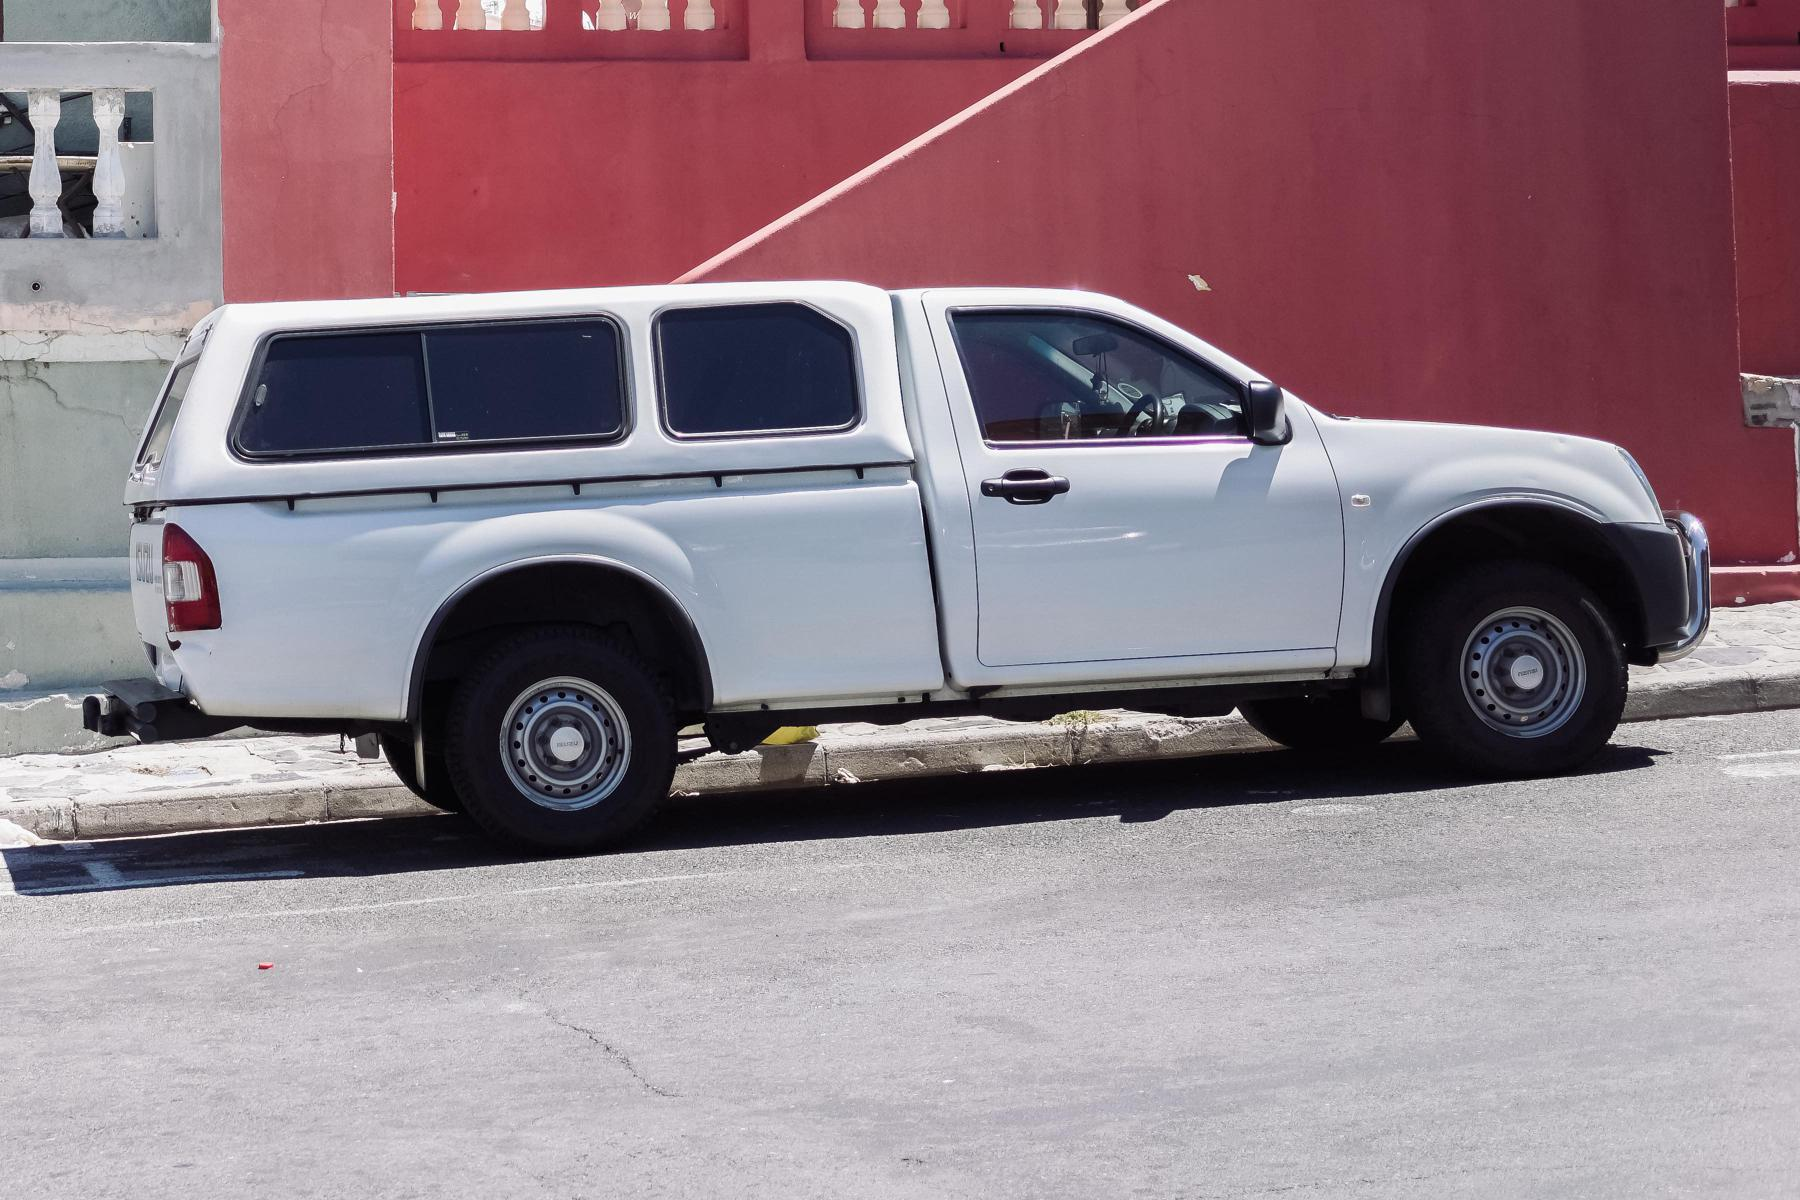

In [19]:
image

In [20]:
image_array.shape

(1200, 1800, 3)

In [21]:
predictor = SAM2ImagePredictor(model)
predictor.set_image(image)

In [22]:
## generate masks without points
generator.generate(image_array)

[]

## run sam with points

In [13]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [14]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [23]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

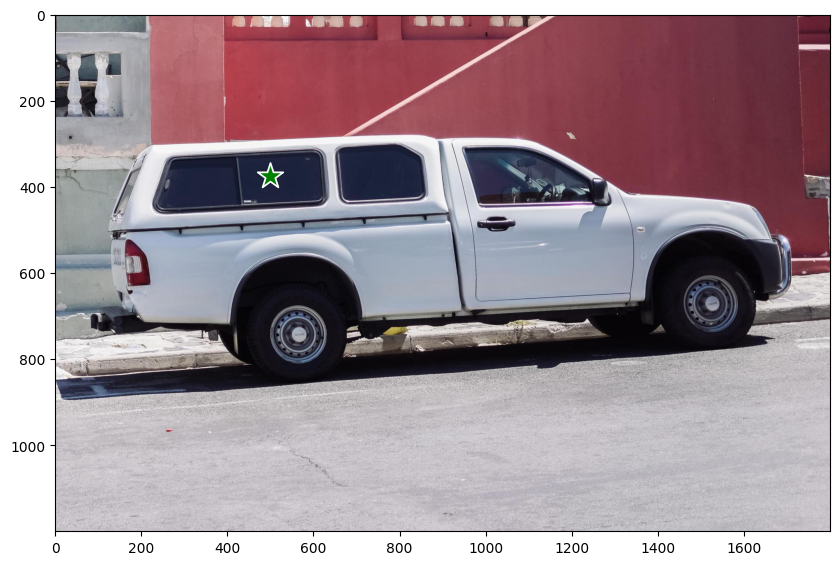

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(image_array)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [25]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [26]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [27]:
masks.shape  # (number_of_masks) x H x W

(3, 1200, 1800)

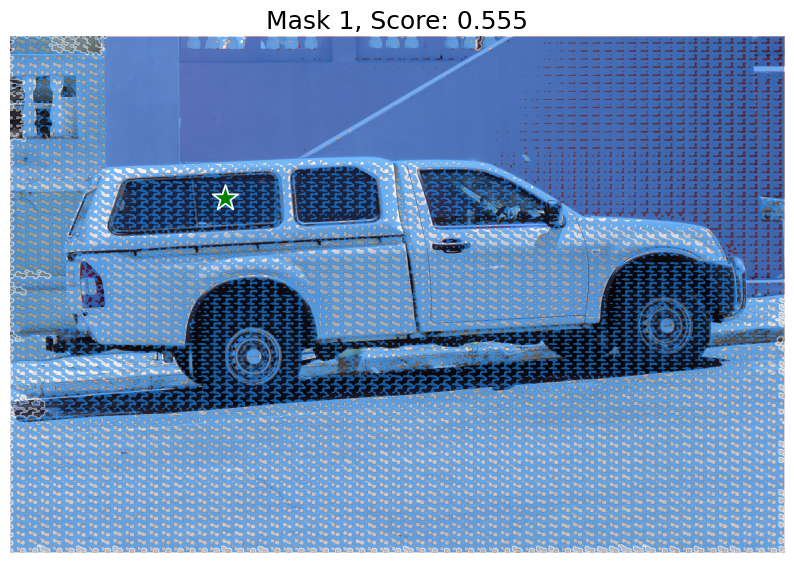

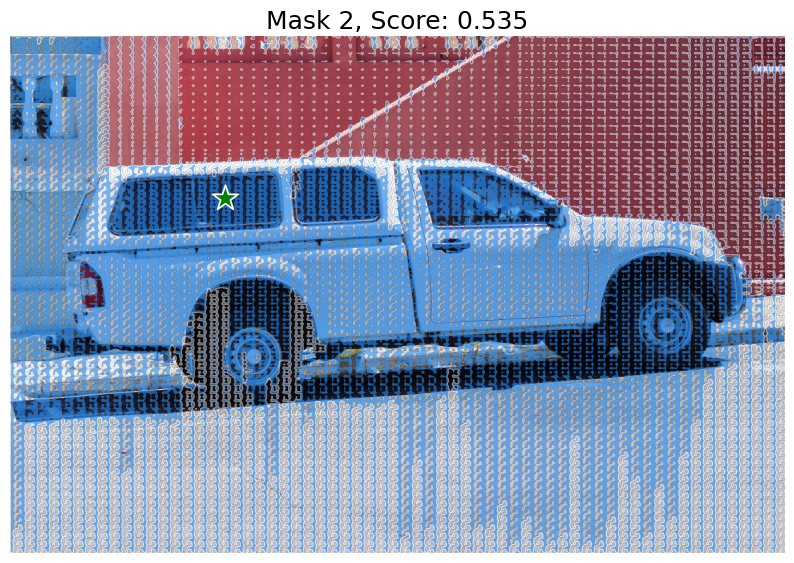

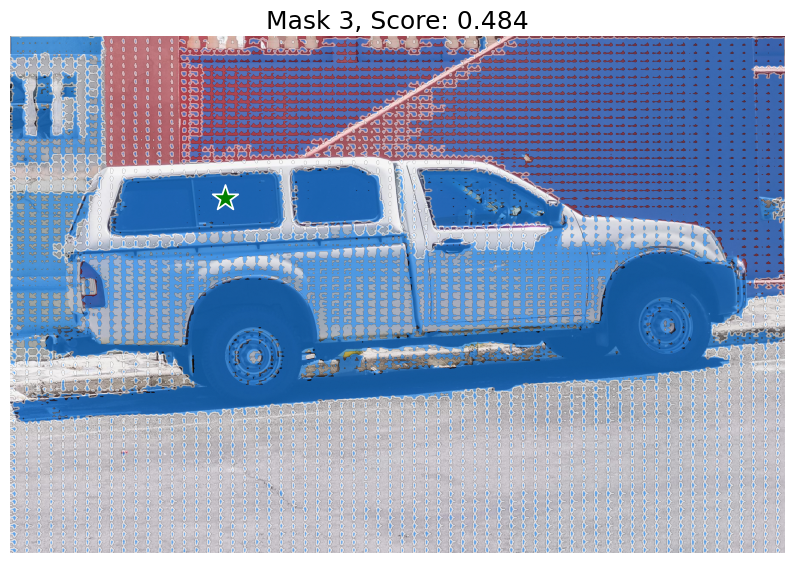

In [28]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

## run sam on video

## run sam with prompts

In [29]:
!pip install groundingdino_py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 22.7 MB/s eta 0:00:00
  Created wheel for groundingdino_py: filename=groundingdino_py-0.4.0-py2.py3-none-any.whl size=88737 sha256=5f3e42ad21d18ab7e93b7e0f9ea1a7908c520dd9b9a02a088139b414b30b5d25
  Stored in directory: /root/.cache/pip/wheels/74/c4/d6/2c6ded61819d391715b4f1ae483f2cfdc8f2eeb6bbb63e748b
Successfully built groundingdino_py


In [30]:
import wget

wget.download("https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth")
wget.download("https://github.com/IDEA-Research/GroundingDINO/blob/main/groundingdino/config/GroundingDINO_SwinT_OGC.py")

'GroundingDINO_SwinT_OGC.py'

In [31]:
!wget -O /content/sam2/GroundingDINO_SwinT_OGC.py https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py


--2025-10-05 16:07:29--  https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1006 [text/plain]
Saving to: ‘/content/sam2/GroundingDINO_SwinT_OGC.py’

/content/sam2/Groun 100%[===================>]    1006  --.-KB/s    in 0s      

2025-10-05 16:07:30 (93.6 MB/s) - ‘/content/sam2/GroundingDINO_SwinT_OGC.py’ saved [1006/1006]



In [32]:
import numpy as np
import torch
from PIL import Image
import re
import os
import gc
import wget
import time
import cv2
from tqdm import tqdm
from typing import Any, Dict, List, Optional, Union
from IPython.display import clear_output

from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import torchvision.datasets as dset

import groundingdino.datasets.transforms as T
from groundingdino.util import box_ops
from groundingdino.util.inference import annotate, load_image, predict
from groundingdino.util.inference import load_model as load_grounding_dino

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Helper functions

In [33]:
def phrases2classes(phrases, classes):
    class_ids = []
    for phrase in phrases:
        for class_ in classes:
            if class_ in phrase:
                class_ids.append(classes.index(class_))
                break
        else:
            class_ids.append(None)
    return np.array(class_ids)

In [34]:
def plot_image_with_predictions(image, predictions, class_list):
    fig, ax = plt.subplots(1, 2, figsize=(24, 8))

    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].set_axis_off()

    ax[1].imshow(image)
    ax[1].set_title('Predictions from Grounded_SAM2')

    unique_pred_list = list(set(predictions["labels"]))
    predefined_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', '#FFA07A', '#8A2BE2', '#00FF00']
    label_to_color = {label: predefined_colors[i % len(predefined_colors)] for i, label in enumerate(unique_pred_list)}

    img_w, img_h = image.size

    for box, mask, label, logits in zip(predictions['boxes'], predictions['masks'], predictions['labels'], predictions['logits']):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logits.item(), 2)
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor=label_to_color[label], linewidth=2)
        ax[1].add_patch(rect)

        # Resize mask to match image shape
        mask_resized = cv2.resize(np.array(mask, dtype=np.uint8), (img_w, img_h), interpolation=cv2.INTER_NEAREST)

        # Plot mask
        ax[1].imshow(mask_resized, cmap=ListedColormap(['none', label_to_color[label]]), alpha=0.5, interpolation='none')

        # Plot logits
        ax[1].text(
            x_min, y_min - 10,
            f'{class_list[label]}: {confidence_score}',
            fontsize=8, ha="left", va="top", color='black',
            bbox={
                "facecolor": "white",
                "edgecolor": label_to_color[label],
                "boxstyle": "square,pad=.3",
            },
            verticalalignment='top'
        )

    plt.axis('off')
    plt.show()

### SAM2 + groundingdino

In [35]:
class GroundedSAM2Wrapper():
    """
    A wrapper for the Grounding-Dino model and SAM2.
    """
    def __init__(self, name, models_path,device):
        self.name = name
        self.device = device
        self.sam_model, self.gdino_model = self._load_models(models_path=models_path,device=device)


    @staticmethod
    def _load_models(models_path: Dict[str, str],device: Optional[str] = 'cpu'):
        """
        Loader method for SAMWrapper

        Parameters
        ----------
        model_paths: Dict[str, str]
            eg: {"model": "path to model"}
        sam_type : str (type of sam model eg: vit-h,vit_l)
        device (str): Device to load the model onto.

        Returns
        -------
        model: torch.nn.Module
        """
        sam_model = models_path['sam_model']
        config_path = models_path['sam_config']
        gdino_weights_path = models_path['gdino_model']
        gdino_config_path = models_path['gdino_config']
        gdino_model = load_grounding_dino( gdino_config_path,gdino_weights_path, device=device)
        sam_model = build_sam2(config_file= config_path,
                                   checkpoint_path=models_path,
                                   device=device,
                                   apply_postprocessing=False)

        sam_model = SAM2ImagePredictor(sam_model)
        return sam_model, gdino_model

    def tokenize(self, prompts: List[str]):
        """
        Converts a list of strings to a single string separated by dots and removes special
        characters.

        Parameters
        ----------
        prompts: List[str]: A list of prompts to be tokenized.

        Returns
        -------
        str: A string containing the labels separated by dots.
        """
        sanitized_labels = self.sanitize_prompts(prompts)
        self.class_labels = sanitized_labels
        class_labels_str = ". ".join(sanitized_labels)
        return class_labels_str

    @staticmethod
    def sanitize_prompts(prompts: List[str]):
        """
        Sanitize a list of prompts by replacing special characters with spaces.

        Parameters
        ----------
        prompts: List[str]
            List of prompts to be sanitized.

        Returns
        -------
        sanitized_labels: List[str]
            Sanitized list of prompts.

        Examples:
        --------
        >>> GroundingDinoWrapper.sanitize_prompts(["red-car", "black_tea", 'two dogs'])
        ['red car', 'black tea', 'two dogs']
        >>> GroundingDinoWrapper.sanitize_prompts(['Another_One', 'Special/Characters',
        ... 'green@mango', 'premium-deal$'])
        ['Another One', 'Special Characters', 'green mango', 'premium deal ']
        """
        # Replace special characters with a space
        pattern = r'[^a-zA-Z0-9\s]'
        sanitized_labels = [re.sub(pattern, ' ', prompt) for prompt in prompts]

        return sanitized_labels

    @staticmethod
    def preprocess_caption(caption: str) -> str:
        """
        Preprocess a caption by converting it to lowercase, stripping whitespace, and ensuring it
        ends with a period
        """
        processed_caption = caption.lower().strip()

        # Ensure the caption ends with a period
        if not processed_caption.endswith("."):
            processed_caption += "."

        return processed_caption

    def encode_tokenized_text(self, text):
      text = self.preprocess_caption(caption=text)
      tokenizer = self.gdino_model.tokenizer
      tokenized_text = tokenizer(text)
      return text, tokenized_text

    def encode_image(self, image):
      transform = T.Compose([
              T.RandomResize([800], max_size=1333),
              T.ToTensor(),
              T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
          ])
      image = transform(image.convert("RGB"), None)[0]
      return image

    def predict_dino(self, image, text,box_threshold,text_threshold):
        boxes=logits=phrases=[]
        trasformed_image = self.encode_image(image)
        trasformed_image = trasformed_image.to(self.device)
        processed_caption,tokenized_text=text
        boxes, logits, phrases = predict(model=self.gdino_model,
                                          image=trasformed_image,
                                          caption=processed_caption,
                                          box_threshold=box_threshold,
                                          text_threshold=text_threshold,
                                          device=self.device)
        W, H = image.size
        boxes = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
        labels = phrases2classes(phrases,self.class_labels)
        return boxes, logits, labels


    def predict_sam2(self, image, boxes):
        mask = torch.tensor([])
        if len(boxes) > 0:
            image_array = np.asarray(image)
            self.sam_model.set_image(image_array)
            mask, scores, _ = self.sam_model.predict(
                                point_coords=None,
                                point_labels=None,
                                box=boxes.numpy(),
                                multimask_output=False,
            )
            mask = torch.from_numpy(mask)
            mask = mask.squeeze(1)

        return mask
    def pred_head(self, images, text, box_threshold=0.3, text_threshold=0.25):
        all_predictions = []
        for image in images:
          boxes, logits, labels = self.predict_dino(image, text, box_threshold, text_threshold)
          masks = self.predict_sam2(image, boxes)
          prediction = {"masks": masks, "boxes":boxes,"logits":logits,"labels":labels}
          all_predictions.append(prediction)


        return all_predictions

In [36]:
from huggingface_hub import whoami

try:
    info = whoami()
    print("✅ Logged in as:", info["name"])
except Exception as e:
    print("❌ Not logged in or invalid token:", e)


✅ Logged in as: deathxxx


In [37]:
wrapper_class = GroundedSAM2Wrapper("Grounded_SAM2",models_path={"sam_model":"/content/sam2/sam2.1_hiera_large.pt",
                                                               "sam_config":"configs/sam2.1/sam2.1_hiera_l.yaml",
                                                               "gdino_model":'/content/sam2/groundingdino_swint_ogc.pth',
                                                               "gdino_config":"/content/sam2/GroundingDINO_SwinT_OGC.py"}
                                   ,device="cuda")
text_encoding = wrapper_class.encode_tokenized_text(wrapper_class.tokenize(["car"]))
pred_list = wrapper_class.pred_head(images=[image],text=text_encoding)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

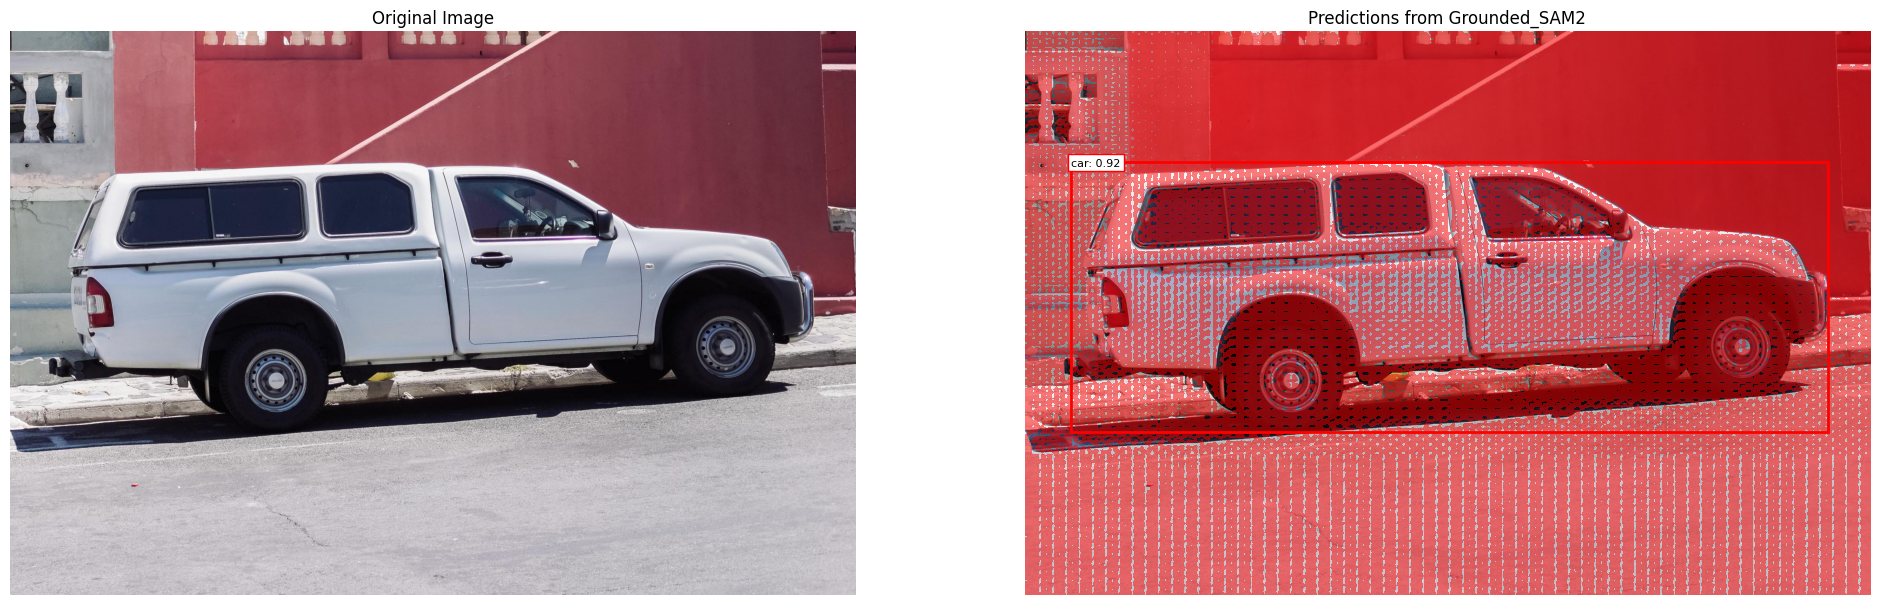

In [38]:
# Plot images with predictions
plot_image_with_predictions(image, pred_list[0],['car'])